In [76]:
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
import tensorflow as tf
import matplotlib.pyplot as plt

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUS Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Num GPUS Available:  1
Found GPU at: /device:GPU:0


In [77]:
from sklearn.datasets import fetch_20newsgroups
# We want to use all categories  so we don't have to declare anything specific for it
newsgroups_train = fetch_20newsgroups(subset='train', shuffle=True)

In [78]:
# Set the features to sentences then see a preview
sentences = newsgroups_train.data
print(sentences[1])

# Set the labels as the target then get a preview and see how many unique values we have
y = newsgroups_train.target
print(y[1])
print(np.unique(y))


From: guykuo@carson.u.washington.edu (Guy Kuo)
Subject: SI Clock Poll - Final Call
Summary: Final call for SI clock reports
Keywords: SI,acceleration,clock,upgrade
Article-I.D.: shelley.1qvfo9INNc3s
Organization: University of Washington
Lines: 11
NNTP-Posting-Host: carson.u.washington.edu

A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the next two days, so please add to the network
knowledge base if you have done the clock upgrade and haven't answered this
poll. Thanks.

Guy Kuo <guykuo@u.washington.edu>

4
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [79]:
# Tokenizing data
tokenizer = Tokenizer(num_words=6000)
tokenizer.fit_on_texts(sentences)

# Prepping data for embedding layer
max_review_len = max(len(s.split()) for s in sentences)
vocab_size = len(tokenizer.word_index)+1
sentences = tokenizer.texts_to_sequences(sentences)
padded_docs = pad_sequences(sentences, maxlen=max_review_len)

print(padded_docs[1])

# Split the data  
X_train, X_test, y_train, y_test = train_test_split(padded_docs, y, test_size=0.25, random_state=1000)

[  0   0   0 ... 118 441  15]


Here we add the embedding and flattening layers to our model. Because we're evaluating 20  categories we revert to softmax and sparse categorical crossentropy.

In [80]:
with tf.device('/gpu:0'):
  model = Sequential()
  model.add(Embedding(vocab_size, 50, input_length=max_review_len))
  model.add(Flatten())
  model.add(layers.Dense(300, activation='relu'))
  model.add(layers.Dense(20, activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['acc'])
  history=model.fit(X_train,y_train, epochs=30, verbose=True, validation_data=(X_test,y_test), batch_size=256)

Epoch 1/30
34/34 [==============================] - 15s 436ms/step - loss: 18.1221 - acc: 0.0515 - val_loss: 3.1109 - val_acc: 0.0329
Epoch 2/30
34/34 [==============================] - 15s 431ms/step - loss: 2.9974 - acc: 0.0652 - val_loss: 2.9822 - val_acc: 0.0923
Epoch 3/30
34/34 [==============================] - 15s 433ms/step - loss: 2.9531 - acc: 0.0813 - val_loss: 2.9508 - val_acc: 0.0802
Epoch 4/30
34/34 [==============================] - 15s 432ms/step - loss: 2.8962 - acc: 0.0900 - val_loss: 2.8509 - val_acc: 0.1166
Epoch 5/30
34/34 [==============================] - 15s 432ms/step - loss: 2.7240 - acc: 0.1533 - val_loss: 2.6713 - val_acc: 0.1828
Epoch 6/30
34/34 [==============================] - 15s 434ms/step - loss: 2.4583 - acc: 0.2532 - val_loss: 2.3258 - val_acc: 0.3121
Epoch 7/30
34/34 [==============================] - 15s 431ms/step - loss: 2.0168 - acc: 0.4420 - val_loss: 1.9663 - val_acc: 0.3899
Epoch 8/30
34/34 [==============================] - 15s 433ms/step -

In [83]:
# Showing the overall accuracy of the model
[test_loss, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc), '\n')


89/89 [==============================] - 2s 20ms/step - loss: 0.9781 - acc: 0.7275
Evaluation result on Test Data : Loss = 0.9780789613723755, accuracy = 0.7274655103683472 



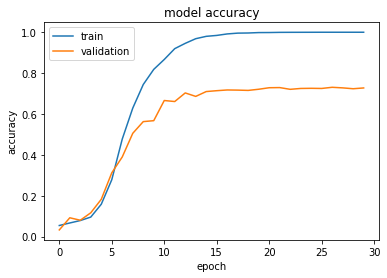

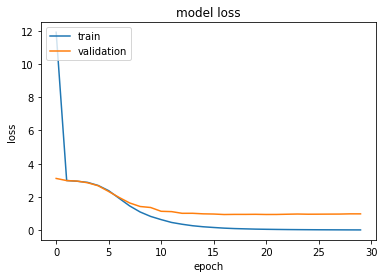

In [84]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()